In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from scipy.interpolate import splprep, splev

# Load Data: AWS Mock Inputs

In [2]:
# Track characteristics
track_length = 50.30
track_width = 1.07

# AWS parameters
waypoints = np.load('../resources/tracks/2022_april_open_ccw.npy')
closest_waypoints = [3, 4]  # mocked

# Load Data: Global Variables

In [3]:
MAX_SPEED = 3.0
MIN_SPEED = 1.0
OPTIMAL_SPEED = (MAX_SPEED + MIN_SPEED)/2

BRAKE_MARKER = 0.15  # trailing % of waypoints considered 

LINEAR_TOLERANCE: float = .1  # deviation to be considered linear
OPTIMAL_PATH_TOLERANCE: float = 0.1  # deviation to be considered on path

In [4]:
waypoints

array([[-1.10870266e-01, -3.28923649e+00,  1.45830503e-01,
        -2.82166814e+00, -3.67571035e-01, -3.75680483e+00],
       [ 3.08530033e-03, -3.35179949e+00,  2.59786099e-01,
        -2.88423109e+00, -2.53615499e-01, -3.81936789e+00],
       [ 1.17040878e-01, -3.41436247e+00,  3.73741687e-01,
        -2.94679405e+00, -1.39659930e-01, -3.88193088e+00],
       ...,
       [-5.25053859e-01, -3.06184399e+00, -2.68352211e-01,
        -2.59427595e+00, -7.81755507e-01, -3.52941203e+00],
       [-2.60984318e-01, -3.20682204e+00, -4.28316323e-03,
        -2.73925400e+00, -5.17685473e-01, -3.67439008e+00],
       [-1.10870266e-01, -3.28923649e+00,  1.45830503e-01,
        -2.82166814e+00, -3.67571035e-01, -3.75680483e+00]])

In [5]:
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

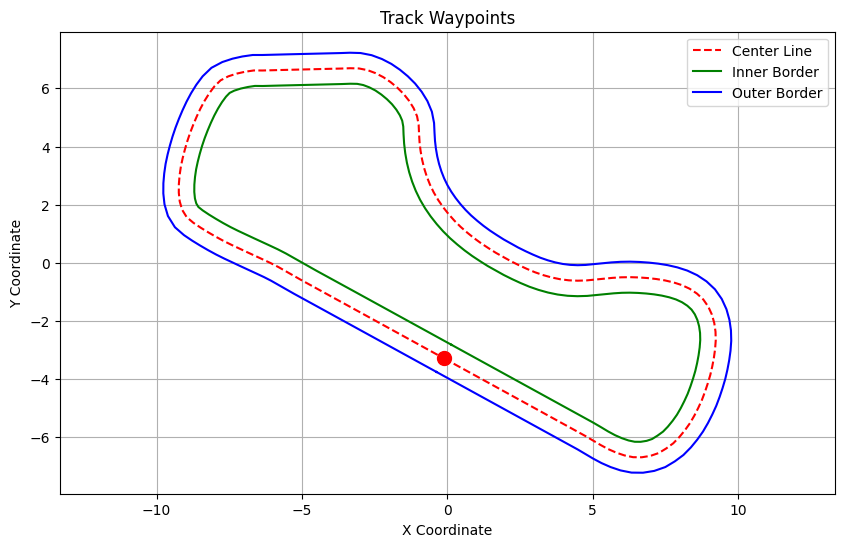

In [6]:
def plot_track(center_line, inner_border, outer_border, closest_waypoints=None):
    center_x, center_y = center_line[:, 0], center_line[:, 1]
    inner_x, inner_y = inner_border[:, 0], inner_border[:, 1]
    outer_x, outer_y = outer_border[:, 0], outer_border[:, 1]
    
    # Plot the waypoints
    plt.figure(figsize=(10, 6))
    plt.plot(center_x, center_y, 'r--', label='Center Line')
    plt.plot(inner_x, inner_y, 'g-', label='Inner Border')
    plt.plot(outer_x, outer_y, 'b-', label='Outer Border')
    
    if closest_waypoints is not None:
        closest_waypoints = [0, 1]
        plt.scatter(waypoints[closest_waypoints[0], 0], waypoints[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    
    # Add labels and legend
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Track Waypoints')
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.axis('equal')  # Ensures equal scaling for x and y axes
    plt.show()
    
plot_track(center_line, inner_border, outer_border, closest_waypoints)

# Split Waypoints: Previous & Upcoming

In [7]:
# with the next waypoint as index, split points into two lists, previous and upcoming

def split_waypoints(points, closest_waypoints):
    # circular split list, from given closest (next) waypoint
    index = closest_waypoints[1]
    if not (0 <= index < len(points)):
        raise ValueError('index out of range')
    
    n = len(points)
    upcoming_points: list = []
    previous_points: list = []
    
    for i in range(index, index + (n//2)):
        upcoming_points.append(points[i % n])
    
    for i in range(index - 1, index - 1 - (n//2), -1):
        previous_points.append(points[i % n])
        
    return previous_points, upcoming_points

previous_points, upcoming_points = split_waypoints(center_line, closest_waypoints)
print('All waypoints:', len(waypoints))
print('---')
print('Previous waypoints:', len(previous_points))
print('Upcoming waypoints:', len(upcoming_points))

All waypoints: 170
---
Previous waypoints: 85
Upcoming waypoints: 85


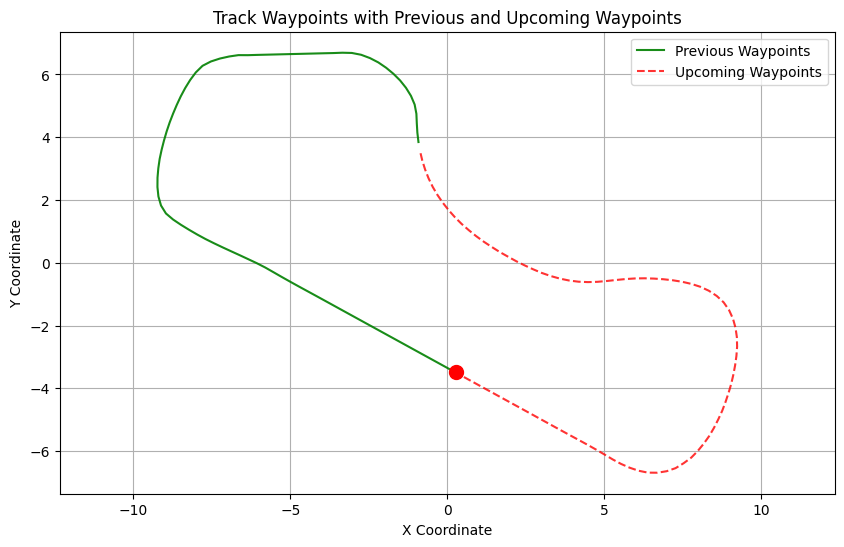

In [8]:
# plot previous and upcoming waypoints
def plot_relative_waypoints(previous_points, upcoming_points, closest_waypoints):
    plt.figure(figsize=(10, 6))
    
    # Plot all waypoints for reference
    center_x, center_y = center_line[:, 0], center_line[:, 1]
    
    # Plot previous waypoints
    previous_points = np.array(previous_points)
    plt.plot(previous_points[:, 0], previous_points[:, 1], 'g-', label='Previous Waypoints',
             markersize=6,
             alpha=0.9)
    
    # Plot upcoming waypoints
    upcoming_points = np.array(upcoming_points)
    plt.plot(upcoming_points[:, 0], upcoming_points[:, 1], 'r--', label='Upcoming Waypoints',
             markersize=5,
             alpha=0.8)
    
    # Highlight the closest waypoints (larger size)
    plt.scatter(waypoints[closest_waypoints[0], 0], waypoints[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    # plt.scatter(waypoints[closest_waypoints[1], 0], waypoints[closest_waypoints[1], 1], color='green', s=100, zorder=5)
    
    # Add labels and legend
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Track Waypoints with Previous and Upcoming Waypoints')
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.axis('equal')  # Ensures equal scaling for x and y axes
    plt.show()

plot_relative_waypoints(previous_points, upcoming_points, closest_waypoints)

# Identify Current Segment Type (Linear, Curve)

## ... linear segment

In [9]:
# for given points, calculate linear equality is within tolerance
def is_linear(segment, tolerance):
    x_coords = [point[0] for point in segment]
    y_coords = [point[1] for point in segment]
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords, rcond=None)[0]

    for x, y in zip(x_coords, y_coords):
        y_estimated = m * x + c
        if abs(y - y_estimated) > tolerance:
            return False
    return True

In [66]:
# iterate over waypoints, returning points within tolerance
def identify_linear_segment(previous_points, upcoming_points, tolerance=LINEAR_TOLERANCE):
    # init lists to store computed segment
    p_segment = []
    u_segment = []
    segment = []
    
    # check initial linear condition
    p1 = previous_points[0]
    u0 = upcoming_points[0]
    u1 = upcoming_points[1]
    init_segment = [p1, u0, u1]
    
    if not is_linear(init_segment, tolerance):
        return np.array(p_segment), np.array(u_segment), np.array(segment)
    
    segment = init_segment

    u_segment = []
    for wp in upcoming_points:
        segment.append(wp)
        if not is_linear(segment, tolerance):
            segment.pop()
            break
        u_segment.append(wp)

    p_segment = []
    for wp in previous_points:
        segment.insert(0, wp)
        if not is_linear(segment, tolerance):
            segment.pop(0)
            break
        p_segment.insert(0, wp)
    
    
    return np.array(p_segment), np.array(u_segment), np.array(segment)

ps, us, current_segment = identify_linear_segment(previous_points, upcoming_points)
print(f'full segment: {len(current_segment)}')
print('---')
print(f'previous points {len(ps)} ({round(len(ps)/len(current_segment), 3)})')
print(f'upcoming points {len(us)} ({round(len(us)/len(current_segment), 3)})')

full segment: 64
---
previous points 39 (0.609)
upcoming points 22 (0.344)


### Handling Output of `identify_linear_segment`

Returning a series of empty lists ? turning
Upcoming segment is an empty list ? turning

Leverage ratio of previous:upcoming points for throttle/brake incentives:
- Upcoming is high% of total segment ? +speed
- Upcoming is low% of total segment ? -speed

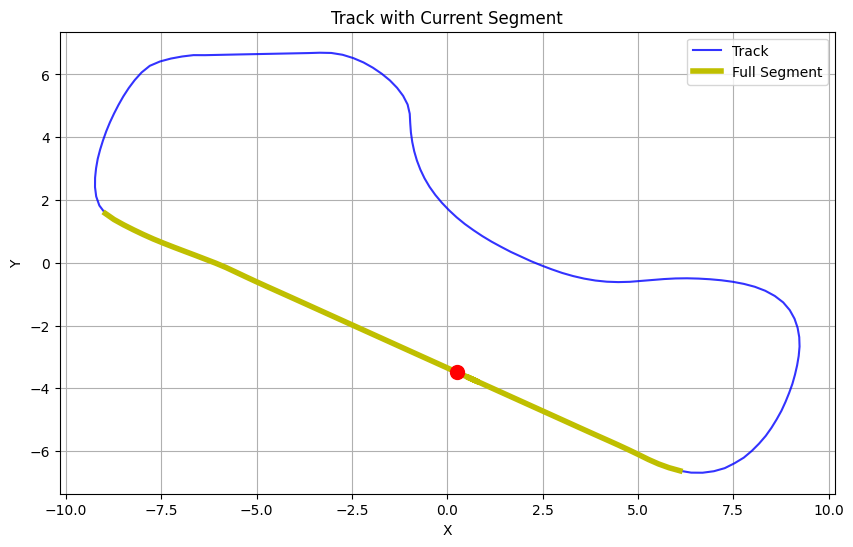

In [55]:
# plot full segment with full track context
def plot_segment_on_track(center_line, current_segment, closest_waypoints):
    plt.figure(figsize=(10, 6))
    plt.plot(center_line[:, 0], center_line[:, 1], 'b-', label='Track',  alpha=.8)
    plt.plot(current_segment[:, 0], current_segment[:, 1], 'y-', label='Full Segment', linewidth=4, alpha=1)
    # plt.plot(us[:, 0], us[:, 1],
    #          'r--',
    #          label='Upcoming Waypoints',
    #          markersize=5,
    #          alpha=1)
    # plt.plot(ps[:, 0], ps[:, 1],
    #          'g--',
    #          label='Previous Waypoints',
    #          markersize=5,
    #          alpha=1)
    
    plt.scatter(center_line[closest_waypoints[0], 0], center_line[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    plt.title('Track with Current Segment')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_segment_on_track(center_line, current_segment, closest_waypoints)

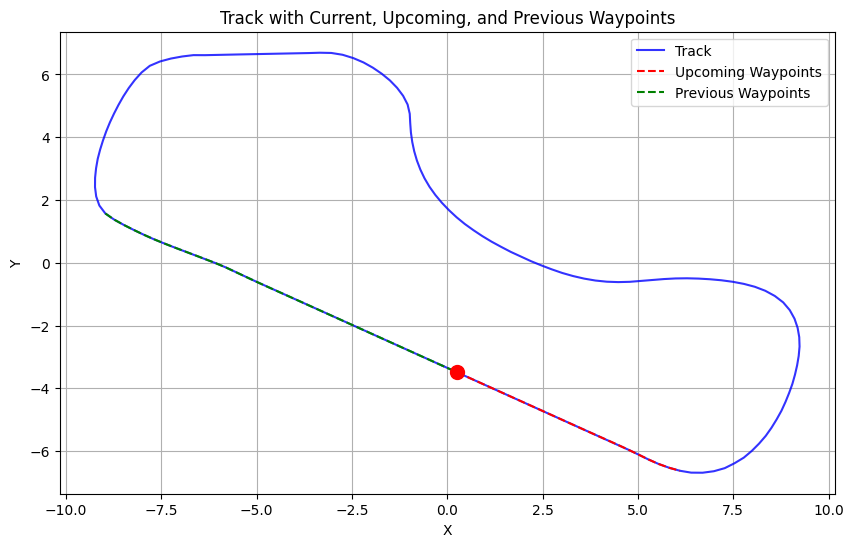

In [58]:
# plot computed previous and upcoming segment waypoints
def plot_segments_on_track(center_line, previous_segment, upcoming_segment, closest_waypoints):
    plt.figure(figsize=(10, 6))
    plt.plot(center_line[:, 0], center_line[:, 1], 'b-', label='Track',  alpha=.8)
    # plt.plot(current_segment[:, 0], current_segment[:, 1], 'y-', label='Full Segment', linewidth=4, alpha=.5)
    plt.plot(upcoming_segment[:, 0], upcoming_segment[:, 1],
             'r--',
             label='Upcoming Waypoints',
             markersize=5,
             alpha=1)
    plt.plot(previous_segment[:, 0], previous_segment[:, 1],
             'g--',
             label='Previous Waypoints',
             markersize=5,
             alpha=1)
    plt.scatter(center_line[closest_waypoints[0], 0], center_line[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    plt.title('Track with Upcoming and Previous Waypoints')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_segments_on_track(center_line, ps, us, closest_waypoints)

In [ ]:
def calculate_optimal_racing_line(straight_segment, waypoints, closest_waypoints, tolerance=LINEAR_TOLERANCE):
    curve_entry_point = straight_segment[-1]
    next_index = closest_waypoints[1] + len(straight_segment)

    remaining_waypoints = waypoints[next_index:]
    next_straight_segment = identify_straight_segment(remaining_waypoints, [0, 1], tolerance)
    curve_exit_point = next_straight_segment[0] if next_straight_segment else waypoints[-1]

    curve_waypoints = waypoints[closest_waypoints[1]:next_index] + [curve_exit_point]

    x = [point[0] for point in curve_waypoints]
    y = [point[1] for point in curve_waypoints]

    tck, u = splprep([x, y], s=0)
    unew = np.linspace(0, 1, 100)
    out = splev(unew, tck)

    optimal_path = list(zip(out[0], out[1]))
    return optimal_path

In [ ]:
def find_optimal_path(waypoints, closest_waypoints, tolerance=LINEAR_TOLERANCE):
    straight_segment = identify_straight_segment(waypoints, closest_waypoints, tolerance)
    optimal_racing_line = calculate_optimal_racing_line(straight_segment, waypoints, closest_waypoints, tolerance)
    return straight_segment, optimal_racing_line